# Actor-Critic Method

In [1]:
from __future__ import print_function

import numpy as np
import random
import matplotlib.pyplot as plt
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

import pygame
import Maze_Solver as maze_solver
from Maze_Solver import MazeSolver, MazeSolverEnv
import Maze_Generator as maze_generator

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
def test(**params):
    
    print(test_01)
        
params = {
    'test_01': 1,
    'test_02': .2,
    'test_03': 'hello world',
    'test_05': {
        'test_05_01': "05_01",
        'test_05_02': "05_02"
    }
}

test(**params)

NameError: name 'test_01' is not defined

In [2]:
# cuda가 설치되어 있다면 cuda를 사용하고 아니라면 cpu만을 사용한다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TensorBoard
writer = SummaryWriter()

![](https://firebasestorage.googleapis.com/v0/b/aing-biology.appspot.com/o/sutton_barto_reinforcement_learning%2Fchapter13%2F01.PNG?alt=media&token=7dbd1717-7691-44fc-9375-c86fe3d04e7a)

In [3]:
class ActorCritic(nn.Module):
    def __init__(self, inputs, outputs):
        super(ActorCritic, self).__init__()
        
        # for Actor
        self.actor_fc1 = nn.Linear(inputs, 256)
        self.critic_fc1 = nn.Linear(inputs, 256)
        self.actor_fc2 = nn.Linear(256, outputs)
        self.critic_fc2 = nn.Linear(256, 1)
        self.head = nn.Softmax(dim=0)
        
        # torch.log makes nan(not a number) error so we have to add some small number in log function
        self.ups=1e-7

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        state = x.to(device)
        probs = F.relu(self.actor_fc1(state))
        probs = self.head(self.actor_fc2(probs))
        
        value = F.relu(self.critic_fc1(state))
        value = self.critic_fc2(value)
        
        return value, probs
    
    def pi(self, s, a):
        s = torch.Tensor(s)
        #s = torch.unsqueeze(s, 0)
        _, probs = self.forward(s)
        probs = torch.squeeze(probs, 0)
        return probs[a]
    
    def get_action(self, state):
        state = torch.tensor(state)
        #state = torch.unsqueeze(state, 0)
        _, probs = self.forward(state)
        probs = torch.squeeze(probs, 0)
        
        action = probs.multinomial(num_samples=1)
        action = action.data
        
        action = action[0]
        return action
    
    def epsilon_greedy_action(self, state, epsilon = 0.1):
        state = torch.tensor(state)
        state = torch.unsqueeze(state, 0)
        _, probs = self.forward(state)
        
        probs = torch.squeeze(probs, 0)
        
        if random.random() > epsilon:
            action = torch.tensor([torch.argmax(probs)])
        else:
            action = torch.rand(probs.shape).multinomial(num_samples=1)
        
        action = action.data
        action = action[0]
        return action
    
    def value(self, s):
        s = torch.tensor(s)
        s = torch.unsqueeze(s, 0)
        value, _ = self.forward(s)
        value = torch.squeeze(value, 0)
        value = value[0]
        
        return value
    
def update_weight(optimizer, states, actions, rewards, last_state, entropy_term = 0):
    # compute Q values
    Qval = actor_critic.value(last_state)
    loss = torch.tensor(0, dtype=torch.float32).to(device)
    # loss obtained when rewards are obtained
    len_loss = len(rewards)
    
    for s_t, a_t, r_tt in reversed(list(zip(states, actions, rewards))):
        log_prob = torch.log(actor_critic.pi(s_t, a_t))
        value = actor_critic.value(s_t)
        Qval = r_tt + GAMMA * torch.clone(Qval)
        
        advantage = Qval - value
        
        actor_loss = (-log_prob * advantage)
        critic_loss = 0.5 * advantage.pow(2)
        
        loss += actor_loss + critic_loss
        
    loss = loss/len_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        

Episode 10 return 33.0
Episode 20 return 17.0
Episode 30 return 15.0
Episode 40 return 27.0
Episode 50 return 16.0
Episode 60 return 14.0
Episode 70 return 41.0
Episode 80 return 36.0
Episode 90 return 24.0
Episode 100 return 10.0
Episode 110 return 11.0
Episode 120 return 27.0
Episode 130 return 14.0
Episode 140 return 49.0
Episode 150 return 40.0
Episode 160 return 25.0
Episode 170 return 30.0
Episode 180 return 49.0
Episode 190 return 29.0
Episode 200 return 33.0
Episode 210 return 64.0
Episode 220 return 20.0
Episode 230 return 102.0
Episode 240 return 24.0
Episode 250 return 51.0
Episode 260 return 12.0
Episode 270 return 53.0
Episode 280 return 38.0
Episode 290 return 15.0
Episode 300 return 56.0
Episode 310 return 13.0
Episode 320 return 40.0
Episode 330 return 31.0
Episode 340 return 47.0
Episode 350 return 46.0
Episode 360 return 23.0
Episode 370 return 58.0
Episode 380 return 39.0
Episode 390 return 83.0
Episode 400 return 61.0
Episode 410 return 102.0
Episode 420 return 42.0

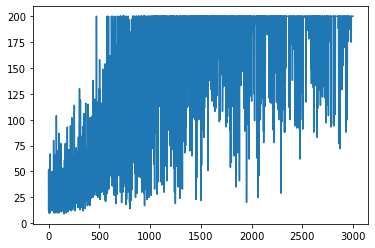

In [4]:
MAX_EPISODES = 3000
MAX_TIMESTEPS = 1000

ALPHA = 3e-4 # learning rate
GAMMA = 0.99 # step-size

#env = MazeSolverEnv()
env = gym.make('CartPole-v0')

#num_actions = env.num_action
num_actions = env.action_space.n
#num_states = 365
num_states = env.observation_space.shape[0]

actor_critic = ActorCritic(num_states, num_actions).to(device)

optimizer = optim.Adam(actor_critic.parameters(), lr=ALPHA)

try:
    returns = []
    
    for i_episode in range(MAX_EPISODES):

        #state = env.init_obs
        state = env.reset()
        init_state = state
        
        done = False
        
        states = []
        actions = []
        rewards = []   # no reward at t = 0

        #while not done:
        for timesteps in range(MAX_TIMESTEPS):
            
            states.append(state)
            
            action = actor_critic.get_action(state)
            actions.append(action)
            
            state, reward, done, _ = env.step(action.tolist())
            rewards.append(reward)

            if done or timesteps == MAX_TIMESTEPS-1:
                last_state = state
                break
        
        update_weight(optimizer, states, actions, rewards, last_state)

        if (i_episode + 1) % 500 == 0:
            print("Episode {} return {}".format(i_episode + 1, sum(rewards)))
            torch.save(actor_critic, './saved_models/actor_critic' + str(i_episode + 1) + '.pt')
        elif (i_episode + 1) % 10 == 0:
            print("Episode {} return {}".format(i_episode + 1, sum(rewards)))
            
        # TensorBoard
        writer.add_scalar("Reward/train", sum(rewards), i_episode+1)
        writer.flush()
            
        returns.append(sum(rewards))
        #env.reset_player(exploring_starts = False)

except KeyboardInterrupt:
    plt.plot(range(len(returns)), returns)
finally:
    plt.plot(range(len(returns)), returns)

env.close()

writer.close()
